In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt

# checking the version of tensorflow
print(tf.__version__) 


# In TensorFlow 2.0 this is the way
# to activate eager execution mode
# and ONLY this way. 
tf.executing_eagerly()


2.0.0


True

In [2]:
# get minst data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.0
x_test =  x_test / 255.0


# add channel 
# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print("training set shape {}".format(x_train.shape))
print("test set shape {}".format(x_test.shape))


    
# shuffle and batch the training set
batch_size = 32 
num_images = 50000

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(num_images).batch(batch_size)


# batch the test set 
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)


training set shape (60000, 28, 28, 1)
test set shape (10000, 28, 28, 1)


In [3]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, InputLayer
from tensorflow.keras import Model
from tensorflow.keras import backend as k 
from tensorflow.python.keras import Sequential

a = tf.keras.backend.placeholder(dtype=tf.float32, shape=(None, 28,28,1))

model = Sequential(

    [   InputLayer( input_shape=( 28,28,1), name="input"),
        Conv2D(32, 3, activation='relu',padding='same',name="conv1" ),
        Conv2D(28, 3, activation='relu',padding='same',name="conv2" ),
        Conv2D(16, 3, activation='relu',padding='same',name="conv3" ),
        
        Flatten(),
        Dense(128, input_shape=(25088,1), name="fc1", activation="relu"),
        Dense(10, input_shape=(128,1), name="fc2", activation="softmax"),
    ]
)


model.compile(loss= "sparse_categorical_crossentropy", 
                  optimizer="adam" , 
                  metrics=['accuracy'])

preds = model.fit(x_train, y_train, batch_size=32, epochs=1)



Train on 60000 samples
60000/60000 [==============================] - 16s 273us/sample - loss: 0.1157 - accuracy: 0.9639


In [4]:
@tf.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
   gate_f = tf.cast(op.outputs[0] > 0, "float32") #for f^l > 0
   gate_R = tf.cast(grad > 0, "float32") #for R^l+1 > 0
   return gate_f * gate_R * grad

In [15]:

single_example = x_train[0].reshape(1,28,28,1)


with tf.Graph().as_default().gradient_override_map({"relu": "GuidedRelu"}):
            input_tensors = [model.input]
            gradients = model.optimizer.get_gradients(model.output[0][3], model.input)
            gradient_fun  = Model(inputs=input_tensors, outputs=gradients)
            grad_values = gradient_fun.predict(single_example)

AttributeError: '_GeneratorContextManager' object has no attribute 'gradient_override_map'

In [6]:
np.min(grad_values)

-0.39277148

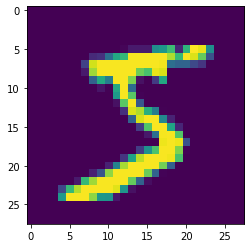

In [7]:
plt.imshow(single_example.reshape(28,28))

## Functional API 


In [8]:

# class MyModel(Model):
#     def __init__(self):
#         super(MyModel, self).__init__()
#         self.conv1 = Conv2D(32, 3, activation='relu',padding='same' )
#         self.flatten = Flatten()
#         self.d1 = Dense(128, activation='relu')
#         self.d2 = Dense(10, activation='softmax')
#         self.conv1_save = []
        
#     def call(self, x):
#         x = self.conv1(x)
#         x = self.flatten(x)
#         x = self.d1(x)
#         return self.d2(x)

# # Create an instance of the model
# model = MyModel()

In [9]:
# # loss function 
# loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

# # adam optimizer
# optimizer = tf.keras.optimizers.Adam()

# train_loss = tf.keras.metrics.Mean(name='train_loss')
# train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

# test_loss = tf.keras.metrics.Mean(name='test_loss')
# test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# @tf.function
# def train_step(images, labels):

#     with tf.GradientTape() as tape:
    
#         predictions = model(images, training=True)
#         loss = loss_object(labels, predictions)
    
#     # apply gradients
#     gradients = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
#     # calculate training loss 
#     train_loss(loss)
#     train_accuracy(labels, predictions)
    
# @tf.function
# def test_step(images, labels):
  
#     predictions = model(images, training=False)
#     t_loss = loss_object(labels, predictions)

#     test_loss(t_loss)
#     test_accuracy(labels, predictions)



In [10]:
# EPOCHS = 1

# for epoch in range(EPOCHS):
#     # reset metrics for train set
#     train_loss.reset_states()
#     train_accuracy.reset_states()
    
#     # rest metrics for test set
#     test_loss.reset_states()
#     test_accuracy.reset_states()

#     # run training step
#     for images, labels in train_ds:
#         train_step(images, labels)
    
#     # run test set 
#     for test_images, test_labels in test_ds:
#         test_step(test_images, test_labels)

#     # print the epoch number, loss and various metrics
#     template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
#     print(template.format(epoch+1,
#                             train_loss.result(),
#                             train_accuracy.result()*100,
#                             test_loss.result(),
#                             test_accuracy.result()*100))

In [11]:
# with tf.Graph().as_default() as g:
#     with g.gradient_override_map({"Relu": "GuidedRelu"}):
#         with tf.GradientTape() as tape:
#             predictions = model(single_example)
#             loss = predictions[:, 3]



In [12]:

# import cv2

# gradients = model.optimizer.get_gradients(model.output[0][3], model.input)

# grad_model = tf.keras.models.Model([model.inputs], [model.get_layer("conv3").output, model.output])
# possible_backprop =  tf.keras.models.Model(model.inputs, gradients)
# grads = possible_backprop.predict(single_example)

# # with tf.GradientTape() as tape:
# #     predictions = possible_backprop(tf.convert_to_tensor(single_example))
# #     loss = predictions[:, 3]

# # output = conv_outputs[0]
# # grads = tape.gradient(loss, )

# gate_f = tf.cast(output > 0, 'float32')
# gate_r = tf.cast(grads > 0, 'float32')
# guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

# weights = tf.reduce_mean(guided_grads, axis=(0, 1))

# cam = np.ones(output.shape[0: 2], dtype = np.float32)

# for i, w in enumerate(weights):
#     cam += w * output[:, :, i]

# cam = cv2.resize(cam.numpy(), (28, 28))
# cam = np.maximum(cam, 0)
# heatmap = (cam - cam.min()) / (cam.max() - cam.min())

# cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

# output_image = cv2.addWeighted(cv2.cvtColor(single_example.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)

# cv2.imwrite('cam.png', output_image)


In [13]:
# import matplotlib.pyplot as plt 
# plt.imshow(cam)